# Camera Calibration

- ✅ Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- ✅ Apply a distortion correction to raw images.


In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
import glob
import math

# create directories 
if not os.path.exists("undistorted_imgs/"):
    os.makedirs("undistorted_imgs/")
if not os.path.exists("binary_imgs/"):
    os.makedirs("binary_imgs/")
if not os.path.exists("warped_imgs/"):
    os.makedirs("warped_imgs/")    


In [25]:
def show_preview(images, row=2, sizex=60, sizey=35):
    fig = plt.figure(figsize=(sizex, sizey))
    for idx, img in enumerate(images):
        fig.add_subplot(len(images)/2, row, idx+1)
        plt.imshow(img)
    plt.show()

def plot_preview(images, row=2, sizex=60, sizey=35):
    fig = plt.figure(figsize=(sizex, sizey))
    for idx, img in enumerate(images):
        fig.add_subplot(len(images)/2, row, idx+1)
        plt.plot(img)
    plt.show()



In [3]:
cal_images = glob.glob("camera_cal/*.jpg")

# # Show preview of all calibration images
# fig = plt.figure(figsize=(15, 15))
# images = list(map(lambda x: mpimg.imread(x), cal_images))
# show_preview(images, 6, 15, 15)


In [4]:
# Find Chessboard corners for calibration
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
images = []


# Step through the list and search for chessboard corners
for idx, fname in enumerate(cal_images):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points and draw & display corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    else:
        print('Cannot find chessboard corners in ' + fname)
    images.append(img)

# show_preview(images, 6, 15, 15)

Cannot find chessboard corners in camera_cal/calibration5.jpg
Cannot find chessboard corners in camera_cal/calibration4.jpg
Cannot find chessboard corners in camera_cal/calibration1.jpg


In [5]:
# Use object and image points to calibrate camera and undistort images
# Images are output into `undistorted_imgs/`

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

def undistort(fname):
    img = cv2.undistort(mpimg.imread(fname), mtx, dist, None, mtx)
    return fname, img

def save_undistorted(img):
    cv2.imwrite('undistorted_imgs/' + img[0][12:], cv2.cvtColor(img[1], cv2.COLOR_RGB2BGR))
    return img[1]

# # Undistort calibration images for visual check
# images = list(map(lambda x : mpimg.imread(x), glob.glob("camera_cal/*jpg")))
# undists = list(map(lambda x : undistort(x)[1], glob.glob("camera_cal/*jpg")))
# show_preview([j for i in zip(images,undists) for j in i], 4, 40, 120)

# Undistort all test images
images = list(map(lambda x: save_undistorted(undistort(x)), glob.glob("test_images/*jpg")))
# show_preview(images, 4, 40, 20)


# Binary Images

* Use color transforms, gradients, etc., to create a thresholded binary image.


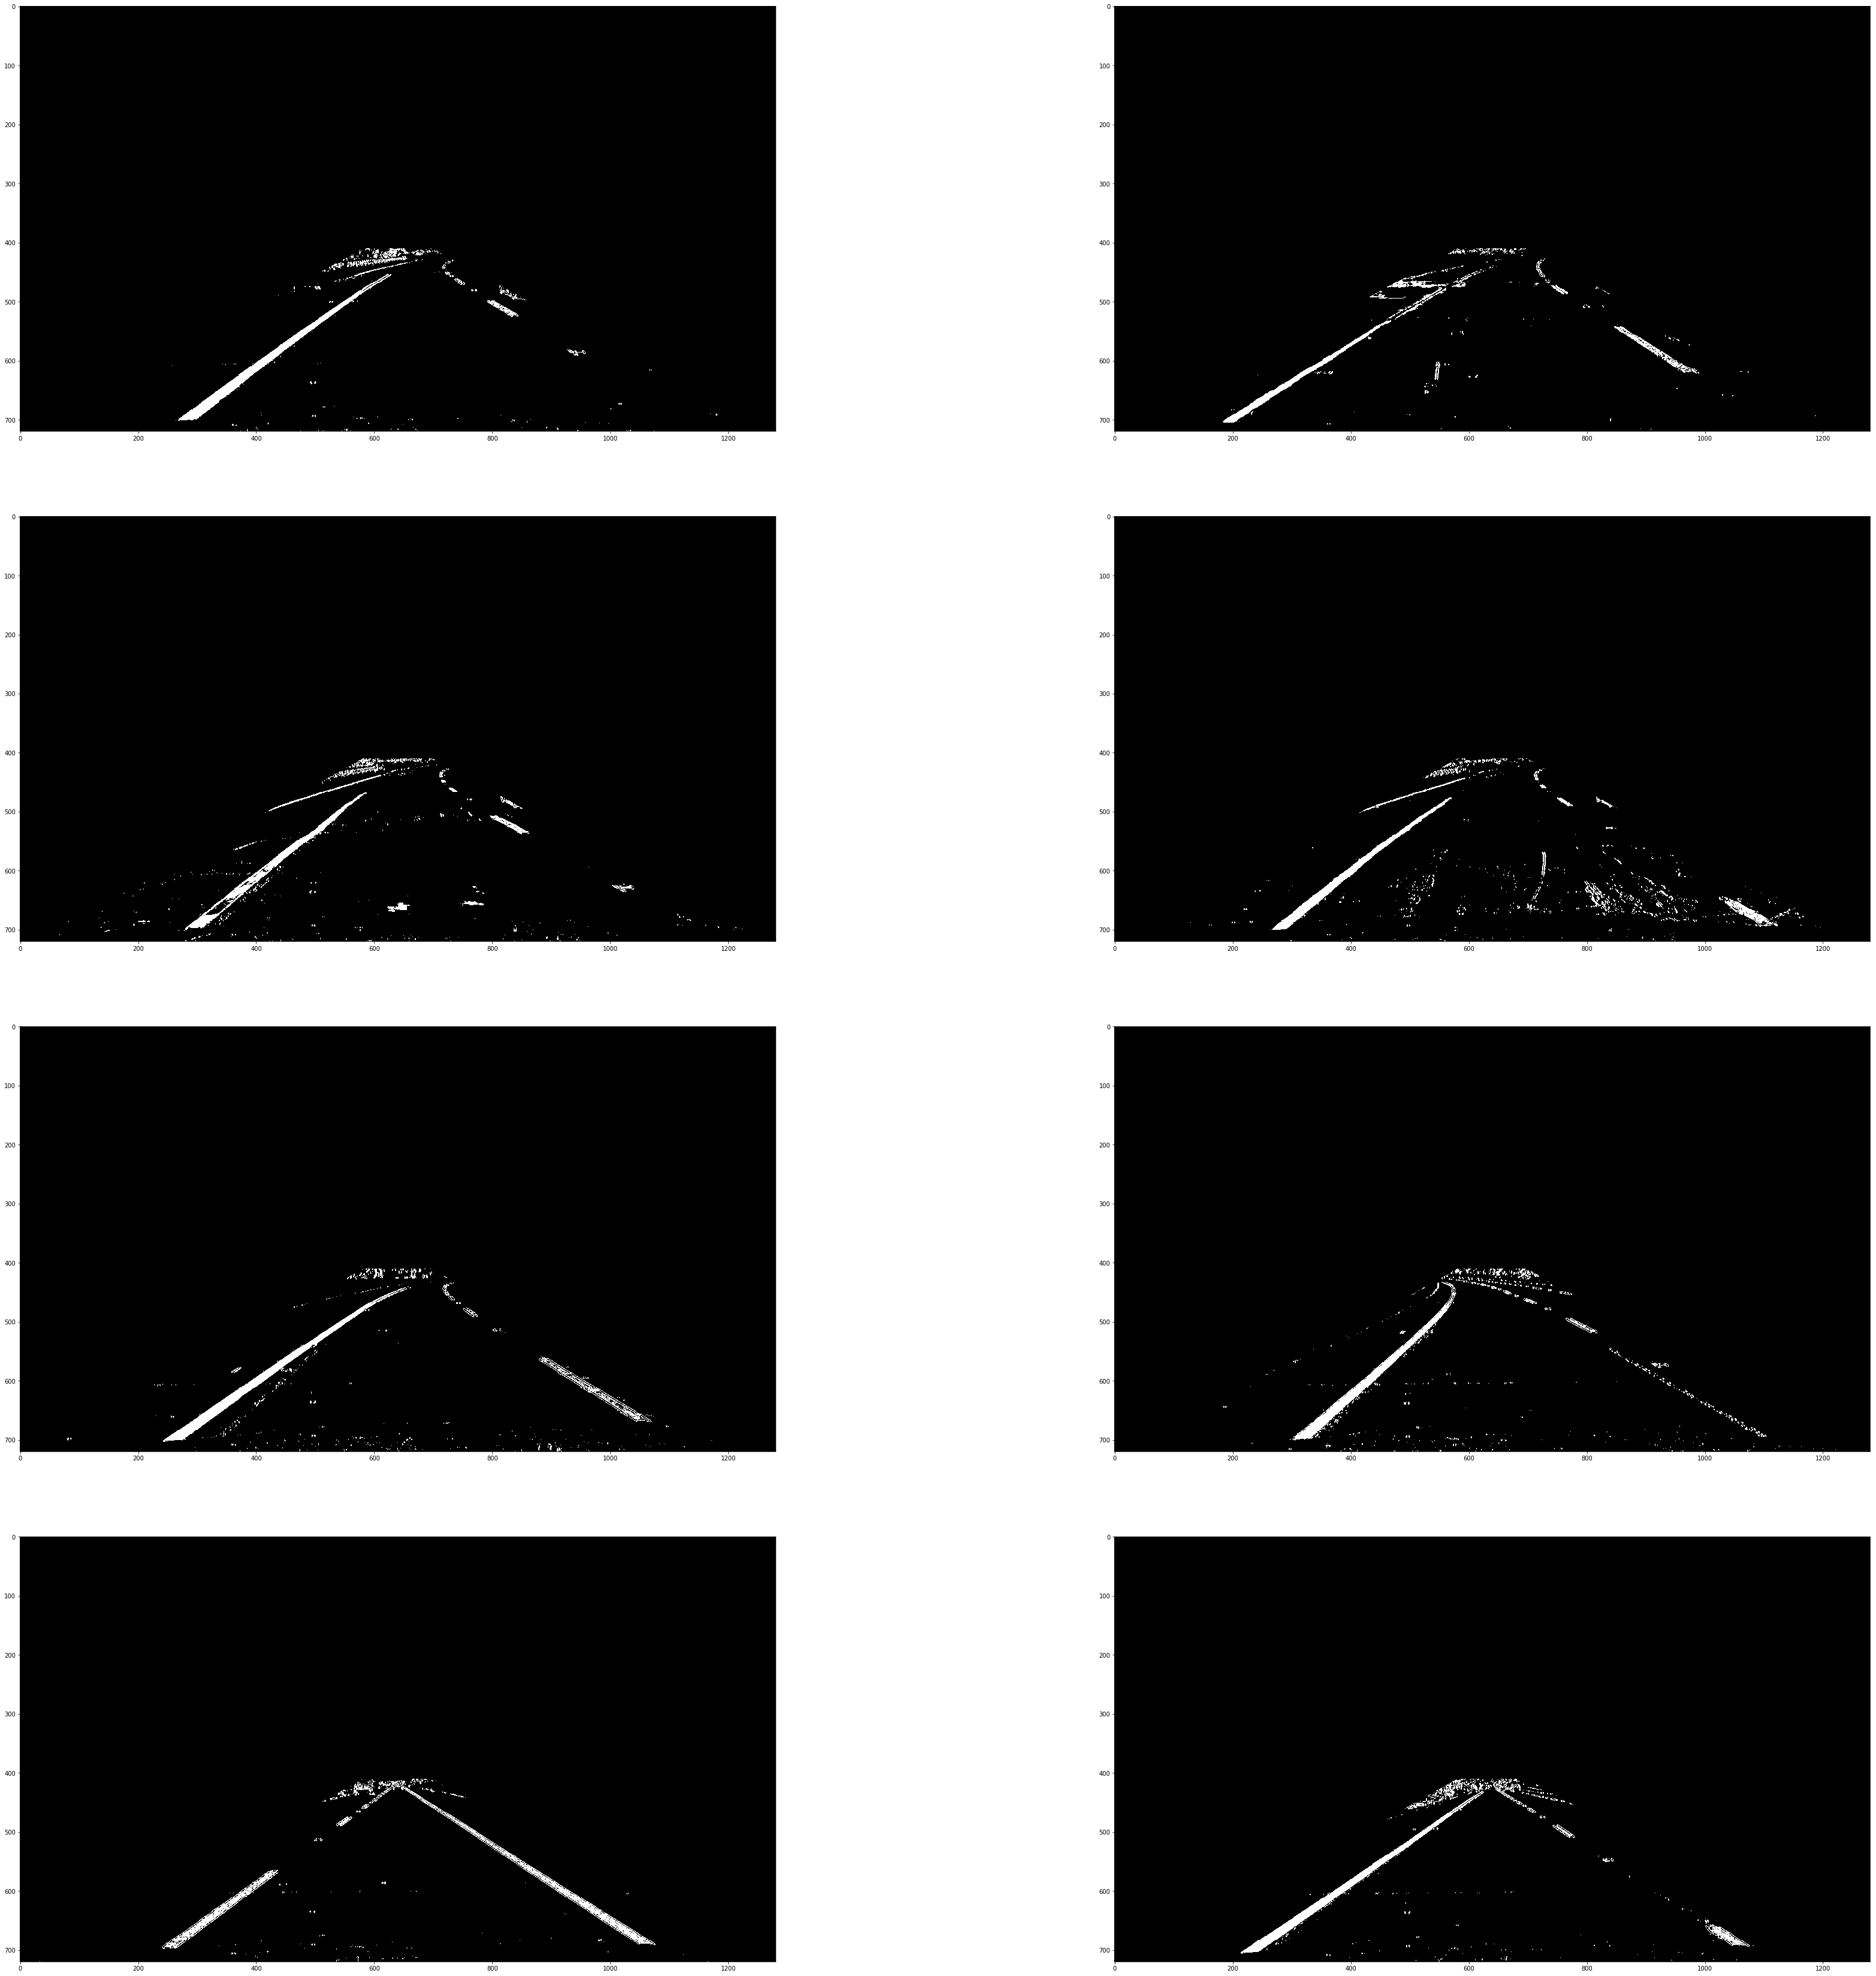

In [44]:
# copied from the lesson and adjusted

def make_binary(img):
    img = img.copy()

    s_thresh=(170, 255)
    sx_thresh=(20, 100)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    real_binary = np.zeros_like(s_binary)
    real_binary[(sxbinary > 0) | (s_binary > 0)] = 255
    real_binary = cv2.cvtColor(real_binary, cv2.COLOR_GRAY2RGB)
    return real_binary

# copied from Project No 1
def get_img_height_width(img):
    img_shape = img.shape
    return img_shape[0], img_shape[1]

def crop_to_roi(img):
    img_height, img_width = get_img_height_width(img)
    vertices = np.array([[(20,img_height),
                          ((5/11)*img_width,(4/7)*img_height),
                          ((6/11)*img_width,(4/7)*img_height),
                          (img_width-20,img_height)]],
                          dtype=np.int32)
    return region_of_interest(img, vertices)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


# make all undistorted binary and store them in `binary_imgs` 
images = list(map(lambda x: mpimg.imread(x), glob.glob('undistorted_imgs/*.jpg')))

binaries = [] 

for img in images:
    img = make_binary(img)
    img = crop_to_roi(img)
    binaries.append(img)

for img in zip(glob.glob('undistorted_imgs/*.jpg'), binaries):
    cv2.imwrite('binary_imgs/' + img[0][17:], cv2.cvtColor(img[1], cv2.COLOR_RGB2BGR))

show_preview(binaries, 2, 60, 60)
    


# Perspective

* Apply a perspective transform to rectify binary image ("birds-eye view").


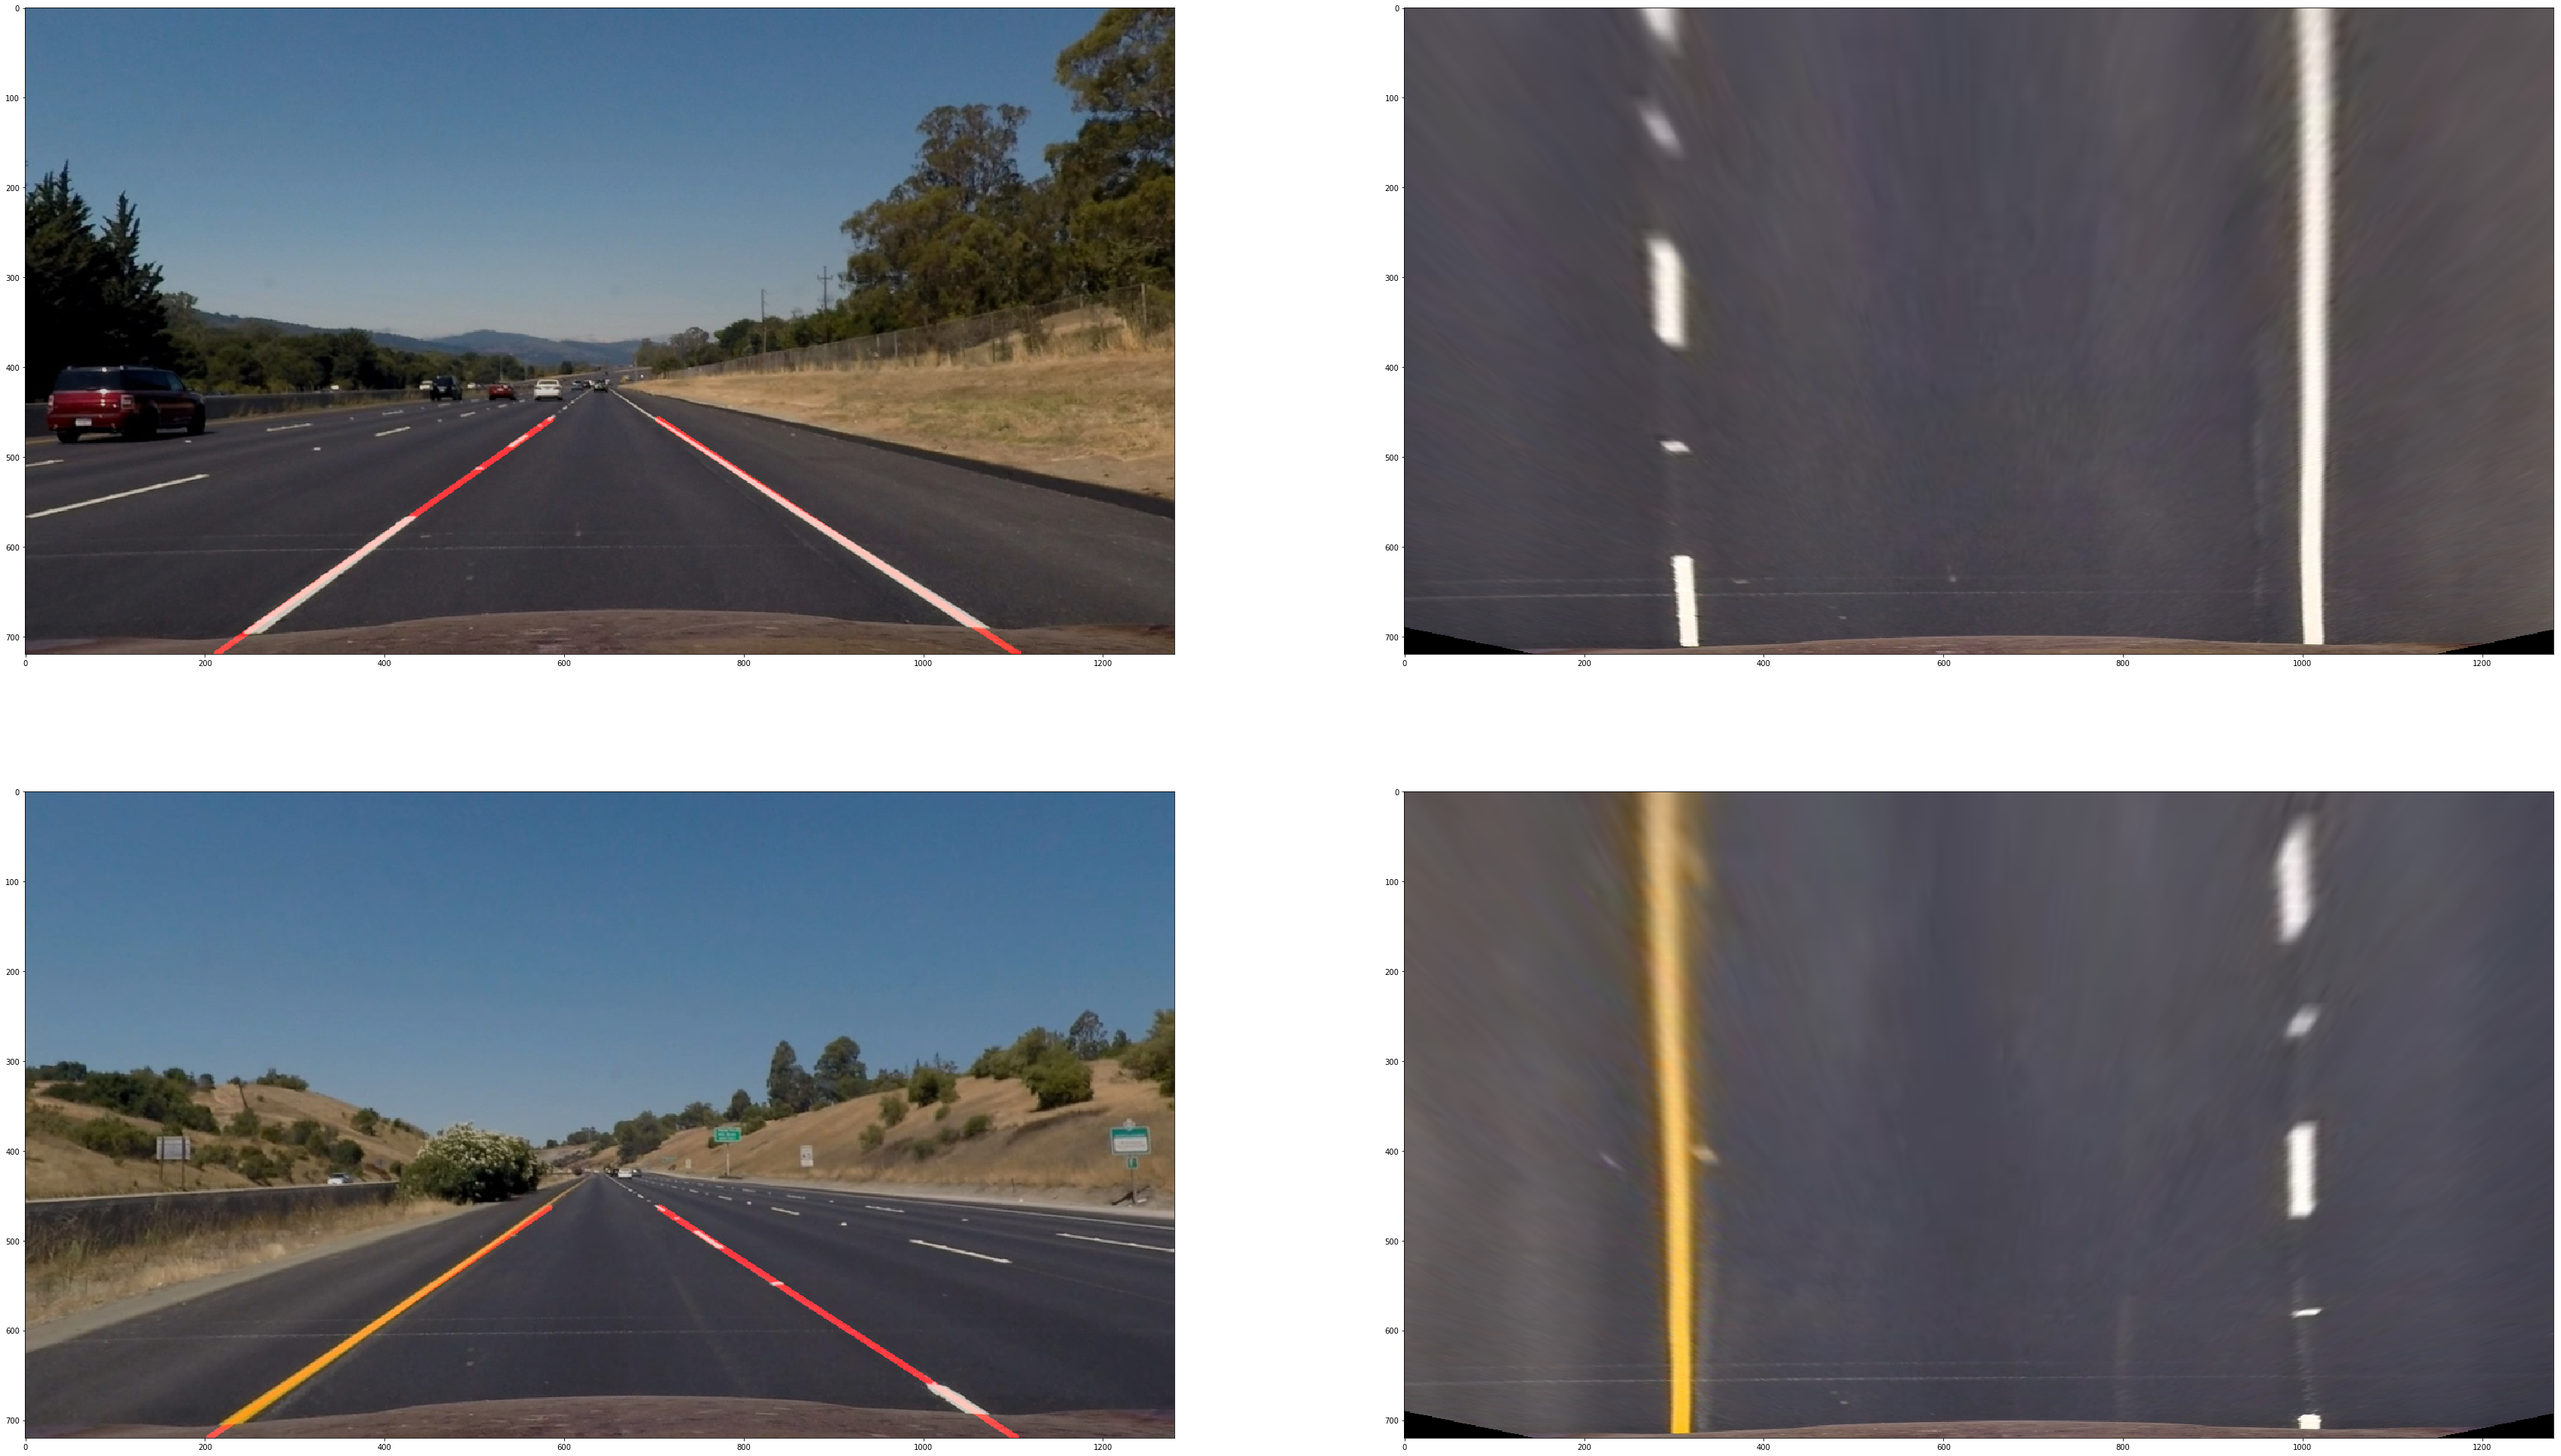

In [86]:
# this is old code from the first projected, slightly adjusted

def get_slope(line):
    for x1,y1,x2,y2 in line:
        return (y2-y1)/(x2-x1)
def get_img_height_width(img):
    img_shape = img.shape
    return img_shape[0], img_shape[1]

def get_intersection(slope1, intercept1, slope2, intercept2):
    intersection_x = (intercept2 - intercept1)/(slope1 - slope2)
    intersection_y = intersection_x * slope1 + intercept1
    return intersection_x, intersection_y

def get_intercept(line):
    slope = get_slope(line)
    for x1,y1,x2,y2 in line:
        return y1 - slope * x1
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def get_avg(data):
    if len(data) == 0:
        return -1
    return sum(data) / len(data)
def extrapolate_lanes(img, lines):
    img_height, img_width = get_img_height_width(img)

    slopes = list(map(lambda line: get_slope(line), lines))
    intercepts = list(map(lambda line: get_intercept(line), lines))

    # group data by slope
    slopes_cp = slopes.copy()
    slopes_cp, intercepts = (list(t) for t in zip(*sorted(zip(slopes_cp, intercepts), key=lambda tup: tup[0])))
    slopes, lines = (list(t) for t in zip(*sorted(zip(slopes, lines), key=lambda tup: tup[0])))

    num_gaps = 0    

    for s in range(len(slopes) - 1):
        if slopes[s+1] - slopes[s] > 0.5 or abs(intercepts[s+1] - intercepts[s]) > 100:
            num_gaps = num_gaps + 1
    
    freq, bins = np.histogram(slopes, num_gaps+1)

    # group detected lines by slopes and intercepts
    bins_slopes = []
    bins_lines = []
    bins_intercepts = []
    bin_start = 0
    for bin_count in range(len(freq)):
        if freq[bin_count] == 0:
            continue
        bins_slopes.append(slopes[bin_start:bin_start+freq[bin_count]])
        bins_lines.append(lines[bin_start:bin_start+freq[bin_count]])
        bins_intercepts.append(intercepts[bin_start:bin_start+freq[bin_count]])
        bin_start = bin_start + freq[bin_count]
    
    avg_slopes = list(map(lambda x: get_avg(x), bins_slopes))
    avg_intercepts = list(map(lambda x: get_avg(x), bins_intercepts))

    # tend to cases where more or less than two lanes were identified
    if len(avg_slopes) > 2:
        left_id = -1
        left_intercept = -100000
        right_id = -1
        right_intercept = 100000
        for i in range(len(avg_slopes)):
            if avg_slopes[i] < 0 and avg_intercepts[i] > left_intercept:
                left_id = i
                left_intercept = avg_intercepts[i]
            if avg_slopes[i] > 0 and avg_intercepts[i] < right_intercept:
                right_id = i
                right_intercept = avg_intercepts[i]
        if left_id != -1 and right_id != -1:
            avg_slopes = list((avg_slopes[left_id],avg_slopes[right_id]))
            avg_intercepts = list((avg_intercepts[left_id],avg_intercepts[right_id]))
        elif left_id != -1:
            avg_slopes = avg_slopes[left_id:left_id+1]
            avg_intercepts = avg_intercepts[left_id:left_id+1]
        elif right_id != -1:
            avg_slopes = avg_slopes[right_id:right_id+1]
            avg_intercepts = avg_intercepts[right_id:right_id+1]

    if len(avg_slopes) < 2:
        intersection_x, intersection_y = int(img_width/2), int(img_height/2)
    else:
        intersection_x, intersection_y = get_intersection(avg_slopes[0], avg_intercepts[0], avg_slopes[1], avg_intercepts[1])

    # draw lane lines
    extra_lines = []
    for lane in range(0,len(avg_slopes)):
        x1 = (intersection_y + 40 - avg_intercepts[lane]) / avg_slopes[lane]
        x2 = (img_height - avg_intercepts[lane]) / avg_slopes[lane]
        
        if x1 == float("inf") or x2 == float("inf"):
            continue
        if avg_slopes[lane] == -1 or avg_intercepts[lane] == -1:
            continue

        extra_lines.append([int(x1),
                            int(intersection_y + 40),
                            int(x2),
                            img_height])
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, np.array([extra_lines]), [255, 0, 0], 5)

    return line_img, extra_lines
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def GetPerspectiveTransform(images):
    perspective_transforms = []
    perspective_transforms_inv = []
    annotated_images = []
    for img in images:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img_gaussian = cv2.GaussianBlur(img, (7, 7), 0)
        img_canny = cv2.Canny(img_gaussian, 200, 240)
        img_cropped = crop_to_roi(img_canny)
        lines = cv2.HoughLinesP(img_cropped, 2, np.pi/180, 50, np.array([]), 10, 20)
        extrapolated_lines, line_pxs = extrapolate_lanes(img_cropped, lines)
        img_weighted = weighted_img(extrapolated_lines, img)
        annotated_images.append(img_weighted)  

        # get points from the lanes and know as source points
        src = np.float32([[[line_pxs[0][0],line_pxs[0][1]]],
                          [[line_pxs[0][2],line_pxs[0][3]]],
                          [[line_pxs[1][0],line_pxs[1][1]]],
                          [[line_pxs[1][2],line_pxs[1][3]]]])
        # knowing that the lanes are straight, set destination points in a rectangle
        
#         print(line_pxs)
        dst = np.float32([[[310,50]],
                          [[310,720]],
                          [[1010,50]],
                          [[1010, 720]]])

        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)

        perspective_transforms.append(M)
        perspective_transforms_inv.append(Minv)

    M = np.mean(perspective_transforms, axis=0)
    Minv = np.mean(perspective_transforms_inv, axis=0)
    return M, Minv, annotated_images

images = []
undistorted_straight_imgs = list(map(lambda x: mpimg.imread(x), glob.glob('undistorted_imgs/*straight*.jpg')))  
M, Minv, annotated_images = GetPerspectiveTransform(undistorted_straight_imgs)

for img in undistorted_straight_imgs:
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    images.append(warped)

show_preview([j for i in zip(annotated_images, images) for j in i])    


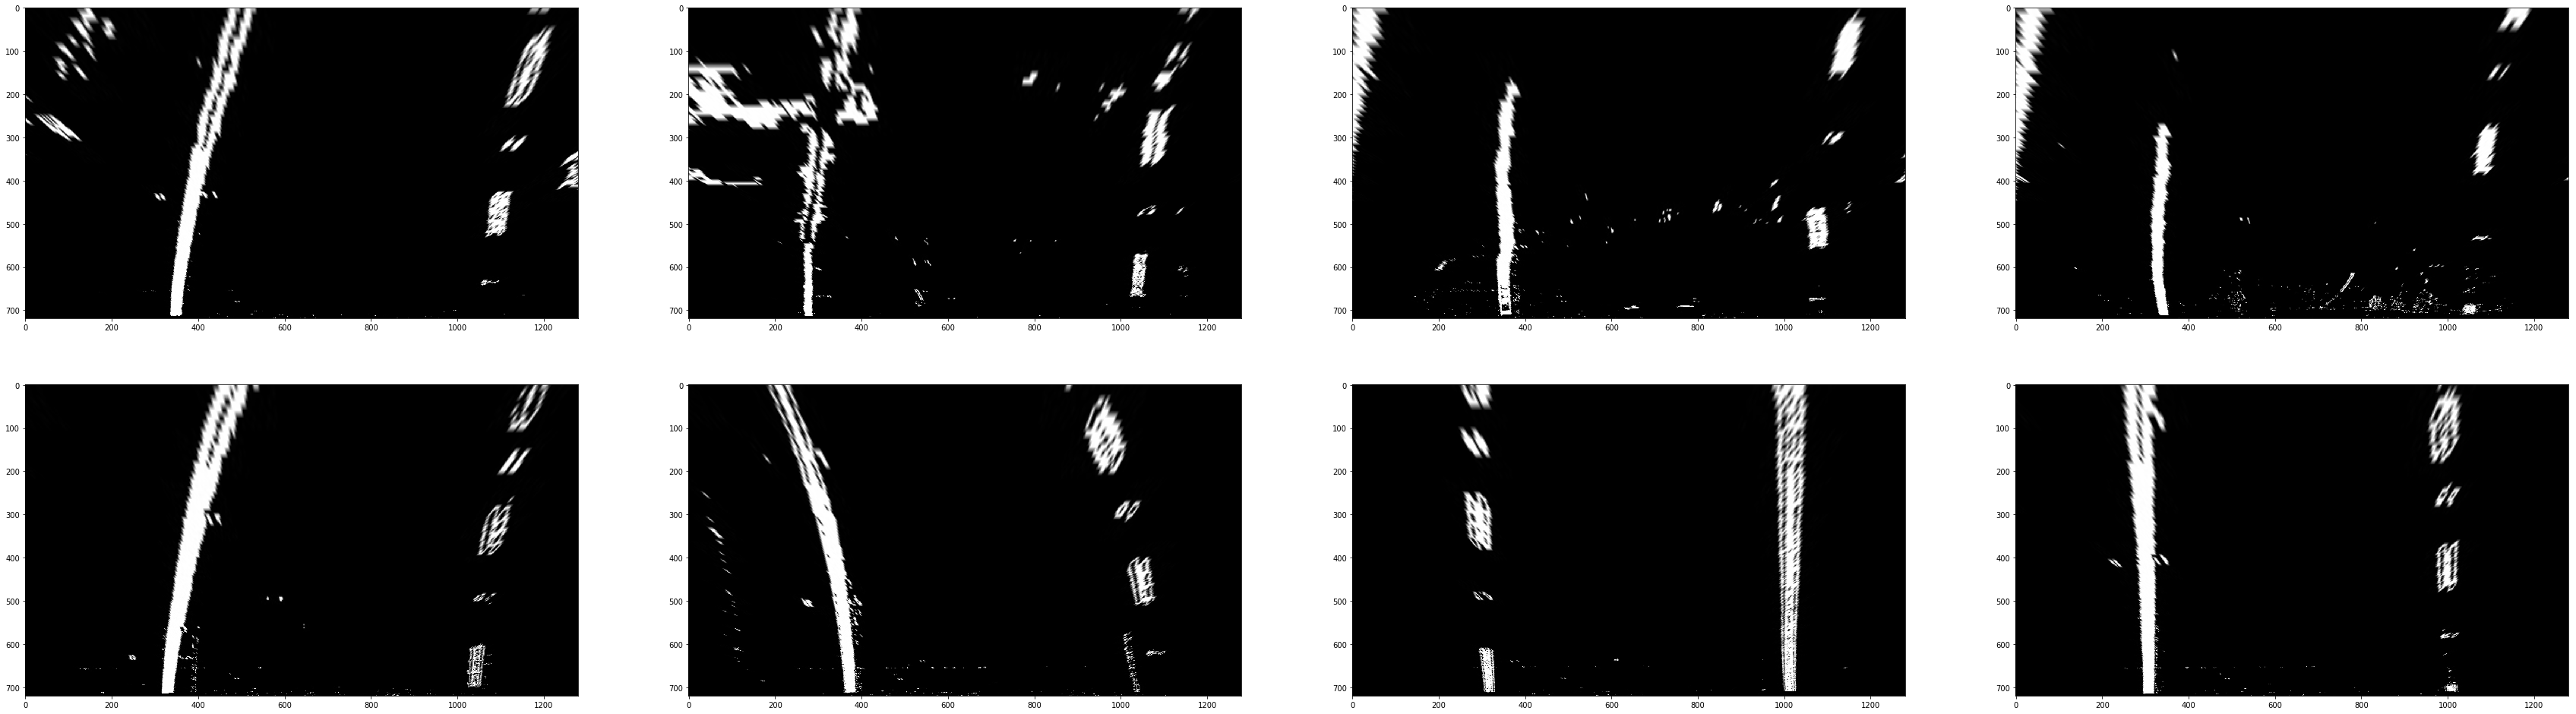

In [87]:
binary_imgs = glob.glob('binary_imgs/*.jpg')  
warped_imgs = []

for idx, binary_img in enumerate(binary_imgs):
    img = mpimg.imread(binary_img)
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    cv2.imwrite('warped_imgs/' + binary_img[12:], warped)
    warped_imgs.append(warped)

show_preview(warped_imgs, 4)    


# Detect Lane Pixels

* Detect lane pixels and fit to find the lane boundary.


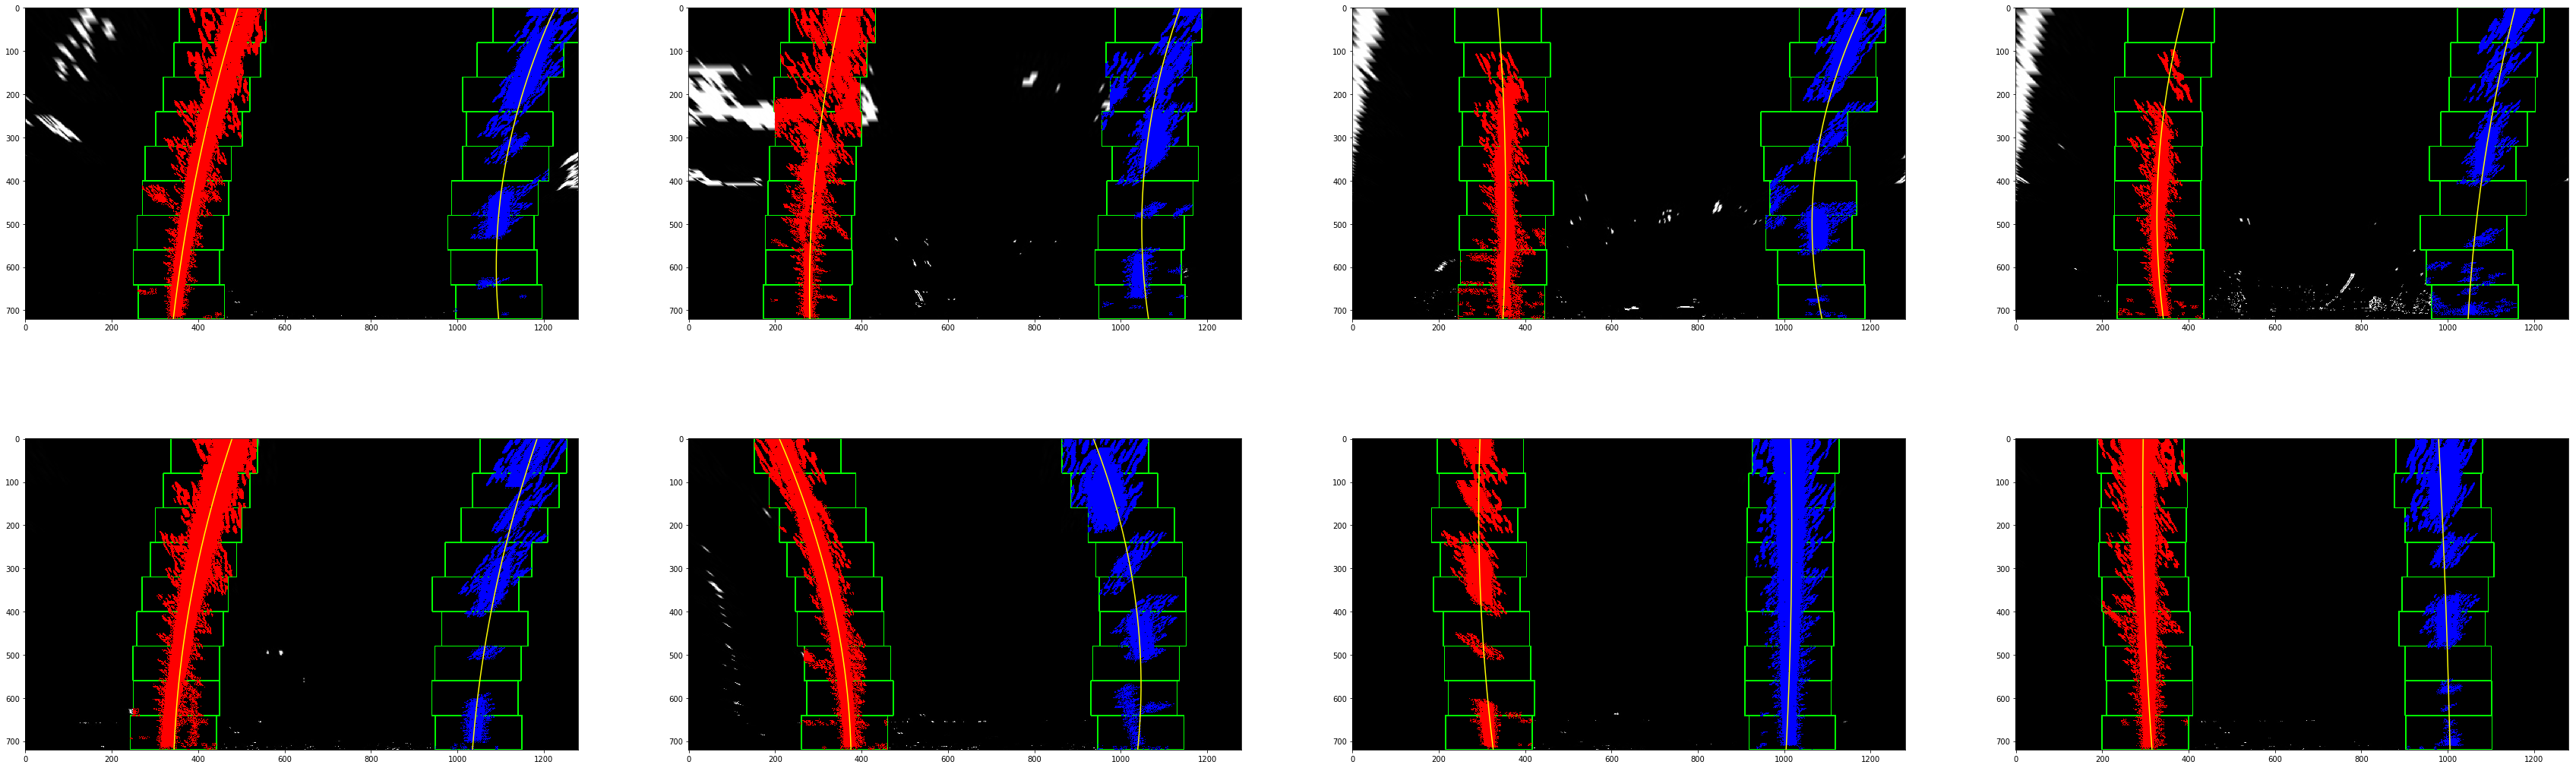

In [91]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit, right_fit, left_fitx, right_fitx


warped_imgs = list(map(lambda x: cv2.cvtColor(mpimg.imread(x), cv2.COLOR_RGB2GRAY), glob.glob('warped_imgs/*jpg')))
images = []

for img in warped_imgs:
    out_img, ploty, left_fit, right_fit, left_fitx, right_fitx = fit_polynomial(img)

    images.append((out_img, ploty, left_fitx, right_fitx))
    
# Visualize the resulting histogram
# show_preview(images, 4)

fig = plt.figure(figsize=(60,40))
                  
# fig = plt.figure()
                  
for idx, img in enumerate(images):
    img, ploty, left_fitx, right_fitx = img
    fig.add_subplot(len(images)/2, 4, idx+1)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')




#     # Create an image to draw the lines on
# #     warp_zero = np.zeros_like(img).astype(np.uint8)
#     color_warp = img

#     # Recast the x and y points into usable format for cv2.fillPoly()
#     pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
#     pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
#     pts = np.hstack((pts_left, pts_right))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

#     # Warp the blank back to original image space using inverse perspective matrix (Minv)
#     newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
#     # Combine the result with the original image
#     result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#     plt.imshow(result)






    plt.imshow(img)
plt.show()




# Fitting Curves

* Determine the curvature of the lane and vehicle position with respect to center.

In [62]:
import numpy as np

    
def measure_curvature_pixels(img):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    out_img, ploty, left_fit, right_fit = fit_polynomial(img)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

warped_imgs = list(map(lambda x: cv2.cvtColor(mpimg.imread(x), cv2.COLOR_RGB2GRAY), glob.glob('warped_imgs/*jpg')))

# Calculate the radius of curvature in pixels for both lane lines
left_curverad, right_curverad = measure_curvature_pixels(warped_imgs[0])

print(left_curverad, right_curverad)
# Should see values of 1625.06 and 1976.30 here, if using
# the default `generate_data` function with given seed number

6561.351246786306 2898.2391014005816
